In [11]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

# redis keys
KOSPI_INDEX = 'I.001_INDEX'

KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [3]:
start = time.time()

agents = ['private', 'forgn', 'inst_sum', 'etc_inst', 'trust', 'pension']
major_agents = ['private', 'forgn', 'inst_sum', 'etc_inst']

# 수급데이터 불러오기
key = tickers[0] + '_BUYSELL'
buysell = pd.read_msgpack(r.get(key))
buysell.set_index('date', inplace=True)
buysell.index = pd.to_datetime(buysell.index)
buysell.drop('code', axis=1, inplace=True)

# OHLCV 데이터 불러오기
key = tickers[0] + '_FULL_OHLCV'
ohlcv = pd.read_msgpack(r.get(key))
ohlcv.set_index('date', inplace=True)
ohlcv.index = pd.to_datetime(ohlcv.index)

# OHLCV + 수급데이터로 하나의 데이터프레임 만들기
data = pd.concat([ohlcv, buysell], axis=1)


##############################################
### DATA 1: 주체별 보유지분 계산한기 (agent_power) ###
##############################################
net_columns = ['{}_n'.format(agent) for agent in agents]
cumsum = data[net_columns].cumsum()
possession = cumsum + cumsum.apply(lambda col: abs(min(col))) # 주체별 보유 주식수
possession['total_stock_num'] = possession.sum(axis=1) # 전체 유통 주식수
# possession 데이터에서 0 제거
possession = possession.replace(0, 1)
# 영향력 계산
power = possession.div(possession['total_stock_num'], axis='index')
power.drop('total_stock_num', axis=1, inplace=True)
new_power_column = [colname[:-1] + 'power' for colname in power.columns]
power.columns = new_power_column
# 데이터에 보유지분 데이터 추가하기
data = pd.concat([data, power], axis=1)


#########################################
### DATA 2: 기관 매수 순도 (institution purity) ###
#########################################
# 기관(inst_sum) 순매수는 다양한 기관들의 매수, 매도를 더한 값이다
# 보통 많은 모든 기관을 고려 안 하고 투신(투자신탁, Trust Fund), 연기금(Pension Fund)만 고려한다.
#이들이 가장 많은 자본을 쥐고 있으며, 그들의 투자 결정에 주가가 영향을 받기 때문이다.
# 그래서 기관의 순도를 확인해야 하는데, 이는: (투신 보유량 + 연기금 보유량) / 기관 보유량
# institution_purity = (trust_n + pension_n) / inst_sum_n
data['institution_purity'] = (possession['trust_n'] + possession['pension_n']) / possession['inst_sum_n']


####################################################
### DATA 3: 거래량 대비 주체별 매매량 (agent_buy_vol_ratio) ###
####################################################
for agent in agents:
    data[agent + '_buy_vol_ratio'] = data[agent + '_b'] / data['trd_qty']
    

##############################################
### DATA 4: 주체별 실제(이론적) 매수금액 (agent_tp) ###
##############################################
# True Price Theory
for agent in agents:
    data[agent + '_tp'] = 0
    data.loc[ (data[agent + '_n'] > 0) & (data['cls_prc'] > data['strt_prc']) , agent + '_tp' ] = (data[agent+'_power']*(((3*data['low_prc'])+data['high_prc'])/4))+((1-data[agent+'_power'])*(((3*data['high_prc'])+data['low_prc'])/4))
    data.loc[ (data[agent + '_n'] > 0) & (data['cls_prc'] == data['strt_prc']) , agent + '_tp' ] = (data['high_prc']+data['low_prc'])/2
    data.loc[ (data[agent + '_n'] > 0) & (data['cls_prc'] < data['strt_prc']) , agent + '_tp' ] = (data[agent+'_power']*(((3*data['low_prc'])+data['high_prc'])/4))+((1-data[agent+'_power'])*(((3*data['high_prc'])+data['low_prc'])/4))

    data.loc[ (data[agent +'_n'] == 0) & (data['cls_prc'] > data['strt_prc']) , agent + '_tp' ] = (data['high_prc']+data['low_prc'])/2
    data.loc[ (data[agent + '_n'] == 0) & (data['cls_prc'] == data['strt_prc']) , agent + '_tp' ] = (data['high_prc']+data['low_prc'])/2
    data.loc[ (data[agent + '_n'] == 0) & (data['cls_prc'] < data['strt_prc']) , agent + '_tp' ] = (data['high_prc']+data['low_prc'])/2

    data.loc[ (data[agent + '_n'] < 0) & (data['cls_prc'] > data['strt_prc']) , agent + '_tp' ] = (data[agent+'_power']*(((3*data['high_prc'])+data['low_prc'])/4))+((1-data[agent+'_power'])*(((3*data['low_prc'])+data['high_prc'])/4))
    data.loc[ (data[agent + '_n'] < 0) & (data['cls_prc'] == data['strt_prc']) , agent + '_tp' ] = (data['high_prc']+data['low_prc'])/2
    data.loc[ (data[agent + '_n'] < 0) & (data['cls_prc'] < data['strt_prc']) , agent + '_tp' ] = (data[agent+'_power']*(((3*data['high_prc'])+data['low_prc'])/4))+((1-data[agent+'_power'])*(((3*data['low_prc'])+data['high_prc'])/4))
    

######################################
### DATA 5: 주체별 평균단가 (agent_apps) ###
######################################
# Average Price Per Share
buy_columns = ['{}_b'.format(agent) for agent in agents]
for agent in agents:
    data[agent + '_buy_cumsum'] = data[agent + '_b'].cumsum()
    data[agent + '_tp*buy'] = data[agent + '_b'] * data[agent + '_tp']
    data[agent + '_tp*buy_cumsum'] = data[agent + '_tp*buy'].cumsum()
    data[agent + '_apps'] = round(data[agent + '_tp*buy_cumsum'] / data[agent + '_buy_cumsum'], 2)
    drop_list = [agent + '_buy_cumsum', agent + '_tp*buy', agent + '_tp*buy_cumsum']
data.drop(drop_list, axis=1, inplace=True)
data.fillna(0, inplace=True)


############################################################
### DATA 6: 주체별 평균단가 & 종가 사이 괴리율 (agent_prc_deviation) ###
############################################################
for agent in agents:
    data[agent + '_prc_deviation'] = data[agent + '_apps'] / data['cls_prc']


########################################################
### DATA 7: 주체별 영향력 + 주도주체 (agent_coef, agent_tvalue) ###
#######################################################
# Power의 변화량이 수익률에 얼마나 영향을 미치는지 회귀분석으로 확인한다
data_m = data[['cls_prc', 'private_power', 'forgn_power', 'inst_sum_power', 'etc_inst_power']].resample('M').last().pct_change().fillna(0)
date_list = sorted(list(set(data_m.index.strftime('%Y-%m'))))
statistic_list = [[date_list[0], 0, 0, 0, 0, 0, 0, 0, 0]]

# Rolling 12-month 회귀분석 (OLS)
j = 0
for i in range(len(date_list[:-1])):
    if i < 12:
        j = j
        result = smf.ols(formula='cls_prc ~ private_power + forgn_power + inst_sum_power + etc_inst_power', data=data_m.loc[date_list[j]:date_list[i]]).fit()
        data_list = [date_list[i+1],
                    abs(float(format(round(result.params[1], 2), '.2f'))),
                    abs(float(format(round(result.params[2], 2), '.2f'))),
                    abs(float(format(round(result.params[3], 2), '.2f'))),
                    abs(float(format(round(result.params[4], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[1], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[2], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[3], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[4], 2), '.2f')))]
        statistic_list.append(data_list)
    else:
        j = j + 1
        result = smf.ols(formula='cls_prc ~ private_power + forgn_power + inst_sum_power + etc_inst_power', data=data_m.loc[date_list[j]:date_list[i]]).fit()
        data_list = [date_list[i+1],
                    abs(float(format(round(result.params[1], 2), '.2f'))),
                    abs(float(format(round(result.params[2], 2), '.2f'))),
                    abs(float(format(round(result.params[3], 2), '.2f'))),
                    abs(float(format(round(result.params[4], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[1], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[2], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[3], 2), '.2f'))),
                    abs(float(format(round(result.tvalues[4], 2), '.2f')))]
        statistic_list.append(data_list)
cols=  ['date', 'private_coef', 'forgn_coef', 'inst_sum_coef', 'etc_inst_coef', 'private_tvalue', 'forgn_tvalue', 'inst_sum_tvalue', 'etc_inst_tvalue']
statistical_df = pd.DataFrame(statistic_list, columns=cols)
statistical_df = statistical_df.set_index('date')
statistical_df.fillna(0, inplace=True)

for agent in major_agents:
    data[agent + '_coef'] = 0
    data[agent + '_tvalue'] = 0
    for date in statistical_df.index:
        data.loc[(data.index.strftime('%Y-%m') == date), agent + '_coef'] = [statistical_df.loc[date][agent + '_coef']] * data[date].shape[0]
        data.loc[(data.index.strftime('%Y-%m') == date), agent + '_tvalue'] = [statistical_df.loc[date][agent + '_tvalue']] * data[date].shape[0]
        
for agent in major_agents:
    data[agent + '_tvalue'] = [3 if x >= 3 else x for x in data[agent + '_tvalue']]
    

########################################################
### DATA 8: 주체별 미래 매수/매도 가능량 (agent_future_buys) #####
#######################################################
for agent in agents:
    power = pd.DataFrame(data[agent + '_power'])
    power['max_power'] = power[agent + '_power'].rolling(200).max()
    power['future_buys'] = power[agent + '_power'] / power['max_power']
    data[agent + '_future_buys'] = power['future_buys']
    
    
# 주체 사이 랭킹이 중요한 요소들: (1) 보유지분, (2) 거래량 대비 매매량, (3) 평균단가 종가 사이 괴리율, (4) 영향력
# 추후, 각 주체들의 수급 상태를 섹션(section)별로 나눠서 랭킹 factor를 곱해주기 때문에,
# 랭킹은 1등: 4, 2등: 3, 3등: 2, 4등: 1 과 같은 방식으로 부여한다.
# 각 factor마다 1 ~ 4위까지 있기 떄문에 총 점수는 최대 16점, 최하 4점이 된다.
# 영향력은 2가지 factor (coefficient, t-value)를 보기 때문에, 랭킹은 각각 0.5, 1, 1.5, 2등으로 매겨서 두 개 랭킹을 합한다.
# 결국, 영향력도 최대 랭킹은 4, 최하 랭킹은 1이 된다.

factors_list = ['_power', '_buy_vol_ratio', '_prc_deviation', '_coef', '_tvalue']

start_making = 1

for factor in factors_list:
    agent_columns = [agent + factor for agent in major_agents]
    temp_data_df = data[agent_columns]
    if factor == '_prc_deviation':
        temp_rank_df = temp_data_df.T.rank(ascending=False).T # 평균단가 종가 사이 괴리율은 작을수록 주도주체일 확률이 높다
    else:
        temp_rank_df = temp_data_df.T.rank(ascending=True).T
    temp_rank_df.rename(columns=lambda colname: colname + '_rank', inplace=True)
    if start_making:
        rank_df = temp_rank_df
        start_making = 0
    else:
        if (factor == '_coef') or (factor == '_tvalue'):
            temp_rank_df = temp_rank_df / 2 # coef, tvalue의 랭킹은 1/2 한다
            rank_df = pd.concat([rank_df, temp_rank_df], axis=1, sort=True)
        else:
            rank_df = pd.concat([rank_df, temp_rank_df], axis=1, sort=True)

agent_rank_df = pd.DataFrame()

for agent in major_agents:
    agent_factors = [agent + factor + '_rank' for factor in factors_list]
    temp_df = rank_df[agent_factors]
    agent_rank_total = temp_df.T.sum()
    agent_rank_df[agent + '_rank'] = agent_rank_total
    

# 주체별 점수 요소: (1) 보유지분, (2) 거래량 대비 매매량, (3) 평균단가 종가 사이 괴리율, (4) 영향력, (5) 미래 매수/매도 가능량
power_bin_cutoffs = []
buy_vol_ratio_bin_cutoffs = []
prc_deviation_bin_cutoffs = []
coef_bin_cutoffs = []
tvalue_bin_cutoffs = []
future_buys_bin_cutoffs = []

for agent in ['forgn', 'inst_sum']:
    power_bin_cutoffs = power_bin_cutoffs + [data[agent + '_power'].min(), data[agent + '_power'].max()]
    buy_vol_ratio_bin_cutoffs = buy_vol_ratio_bin_cutoffs + [data[agent + '_buy_vol_ratio'].min(), data[agent + '_buy_vol_ratio'].max()]
    prc_deviation_bin_cutoffs = prc_deviation_bin_cutoffs + [data[agent + '_prc_deviation'].min(), data[agent + '_prc_deviation'].max()]
    coef_bin_cutoffs = coef_bin_cutoffs + [data[agent + '_coef'].min(), data[agent + '_coef'].max()]
    tvalue_bin_cutoffs = tvalue_bin_cutoffs + [data[agent + '_tvalue'].min(), data[agent + '_tvalue'].max()]
    future_buys_bin_cutoffs = future_buys_bin_cutoffs + [data[agent + '_future_buys'].min(), data[agent + '_future_buys'].max()]
    
for agent in ['forgn', 'inst_sum']:
    bins = np.linspace(min(power_bin_cutoffs), max(power_bin_cutoffs), 10)
    agent_rank_df[agent + '_power_score'] = np.digitize(data[agent + '_power'], bins)
    
    bins = np.linspace(min(buy_vol_ratio_bin_cutoffs), max(buy_vol_ratio_bin_cutoffs), 10)
    agent_rank_df[agent + '_buy_vol_ratio_score'] = np.digitize(data[agent + '_buy_vol_ratio'], bins)
    
    bins = np.linspace(min(prc_deviation_bin_cutoffs), max(prc_deviation_bin_cutoffs), 10)
    agent_rank_df[agent + '_prc_deviation_score'] = np.digitize(data[agent + '_prc_deviation'], bins)
    
    bins = np.linspace(min(coef_bin_cutoffs), max(coef_bin_cutoffs), 10)
    agent_rank_df[agent + '_coef_score'] = np.digitize(data[agent + '_coef'], bins)
    
    bins = np.linspace(min(tvalue_bin_cutoffs), max(tvalue_bin_cutoffs), 10)
    agent_rank_df[agent + '_tvalue_score'] = np.digitize(data[agent + '_tvalue'], bins)
    
    bins = np.linspace(min(future_buys_bin_cutoffs), max(future_buys_bin_cutoffs), 10)
    agent_rank_df[agent + '_future_buys_score'] = np.digitize(data[agent + '_future_buys'], bins)
    
score_factors_list = ['_power_score', '_buy_vol_ratio_score', '_prc_deviation_score', '_coef_score', '_tvalue_score', '_future_buys_score']

for agent in ['forgn', 'inst_sum']:
    agent_rank_df[agent + '_total_score'] = 0
    for factor in score_factors_list:
        if (factor == '_coef_score') or (factor == '_tvalue_score'):
            agent_rank_df[agent + '_total_score'] = agent_rank_df[agent + '_total_score'] + (agent_rank_df[agent + factor] * (1/2))
        else:
            agent_rank_df[agent + '_total_score'] = agent_rank_df[agent + '_total_score'] + agent_rank_df[agent + factor]
            
# agent_rank_df['inst_sum_total_score'] = data['institution_purity'] * agent_rank_df['inst_sum_total_score']
            
for agent in ['forgn', 'inst_sum']:
    agent_rank_df[agent + '_rank*score'] = agent_rank_df[agent + '_rank'] * agent_rank_df[agent + '_total_score']
    
agent_rank_df['Leading Agent'] = agent_rank_df['forgn_rank*score'] > agent_rank_df['inst_sum_rank*score']
agent_rank_df.loc[(agent_rank_df['Leading Agent'] == True), 'Leading Agent Score'] = agent_rank_df['forgn_total_score']
agent_rank_df.loc[(agent_rank_df['Leading Agent'] == False), 'Leading Agent Score'] = agent_rank_df['inst_sum_total_score']

end = time.time()
print('Time took: {}'.format(end - start))

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Time took: 10.142443895339966


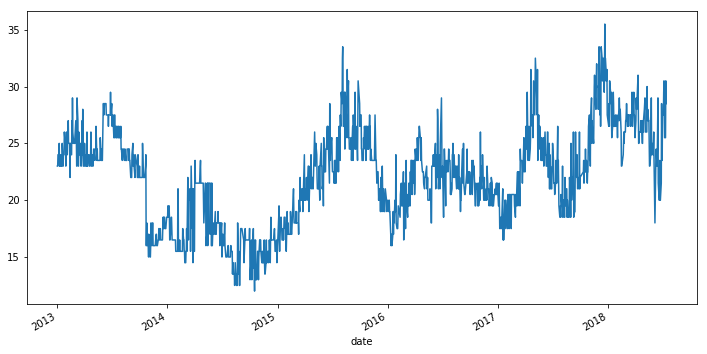

In [12]:
agent_rank_df['Leading Agent Score'].plot()

In [ ]:
# Bayes Rule: P(A | B) = P(B | A) * P(A) / P(B)
# P(forgn_buy > 0 | cls_prc, agent_power, agent_buy_vol_ratio, agent_prc_deviation, agent_future_buys) = P(cls_prc | forgn_buy > 0) * P(agent_power | forgn_buy > 0) * ... * P(forgn_buy > 0)



### Backtesting

시그널을 만들어서 캘리 공식, 손절/익절까지 적용하여 결과물을 백테스팅해본다

In [51]:
def kelly_criterion(rt, kp_ret, window):
    '''
    rt: 종목의 종가로 계산한 리턴값
    kp_ret: 코스피 지수로 계산한 리턴값
    window: rolling시킬 일수 (보통 60 사용)
    '''
    # 배팅 비중 계산 (Kelly Criterion 사용)
    
    # STEP 1: excess return 계산하기
    # 종목 평균 수익률 - 코스피 평균 수익률 (rolling으로 처리하여 계산)
    ret_list = []

    rolling_rt = rt.rolling(window).mean()
    rolling_kp_ret = kp_ret.rolling(window).mean()

    for i in range(len(rt)):
        if i == 0:
            stock_return = rt[i] # nan
            kospi_return = kp_ret[i] # nan
        else:
            stock_return = rt[:i].mean() if i < window else rolling_rt[i]
            kospi_return = kp_ret[:i].mean() if i < window else rolling_kp_ret[i]
        excess_return = stock_return - kospi_return
        ret_list.append(excess_return)

    kelly = pd.DataFrame(ret_list)
    kelly.rename(columns={0: 'Excess Return'}, inplace=True)
    kelly['Excess Return MA'] = kelly['Excess Return'].rolling(window).mean() # excess return의 moving average
    kelly['Excess Return MV'] = kelly['Excess Return'].rolling(window).var() # excess return의 moving variance

    kelly_criterion = []

    for i in range(len(kelly)):
        if i == 0:
            exc_ret_mean = kelly['Excess Return'][i].mean()
            exc_ret_var = kelly['Excess Return'][i].var()
        else:
            exc_ret_mean = kelly['Excess Return'][:i].mean() if i < window else kelly['Excess Return MA'][i]
            exc_ret_var = kelly['Excess Return'][:i].var() if i < window else kelly['Excess Return MV'][i]
        kelly_ratio = exc_ret_mean / exc_ret_var
        kelly_criterion.append(kelly_ratio)

    kelly['Kelly Criterion'] = kelly_criterion
    # 캘리 숫자를 0 ~ 1로 스케일링하기 위해 max, min 구하기
    kelly['Kelly Criterion MAX'] = kelly['Kelly Criterion'].rolling(window).max()
    kelly['Kelly Criterion MIN'] = kelly['Kelly Criterion'].rolling(window).min()

    invest_ratio = []

    for i in range(len(kelly['Kelly Criterion'])):
        
        if i == 0:
            # 시작은 자본금 전체 투자한다
            invest_amt = 1
            
        if i < window:
            # window보다 작은 인덱스값은 위에서 계산한 max, min이 없기 때문에 따로 rolling으로 데이터를 묶어서 max, min을 계산
            kelly_nums = kelly['Kelly Criterion'][:i] # 0 부터 현재값까지 모두 묶기
            max_kelly = kelly_nums.max()
            min_kelly = kelly_nums.min()
            invest_amt = (kelly['Kelly Criterion'][i] - min_kelly) / (max_kelly - min_kelly) if max_kelly - min_kelly != 0 else 1
            
        if i >= window:
            max_kelly = kelly['Kelly Criterion MAX'][i]
            min_kelly = kelly['Kelly Criterion MIN'][i]
            invest_amt = (kelly['Kelly Criterion'][i] - min_kelly) / (max_kelly - min_kelly) if max_kelly - min_kelly != 0 else 1
            
        if pd.isnull(kelly['Kelly Criterion'][i]):
            # 캘리 숫자가 없으면 자본금 모두를 투자 (보통 초기 몇개 빼고는 모두 캘리 숫자가 있다)
            invest_amt = 1
            
        invest_ratio.append(invest_amt)

    # 초기 몇개의 데이터는 음수인 숫자도 있고 1이 훨씬 넘는 숫자도 있다
    # 모두 제거한다
    invest_ratio = [ratio if (ratio <= 1) and (ratio >= 0) else 1 for ratio in invest_ratio]

    kelly['Invest Ratio'] = invest_ratio
    kelly['Invest Ratio'].fillna(1, inplace=True)
    
    return pd.DataFrame(kelly['Invest Ratio'])

In [52]:
def atr(full_df):
    tr = pd.DataFrame()
    tr['H-L'] = full_df['high_prc'] - full_df['low_prc']
    tr['H-P_1'] = (full_df['high_prc'] - full_df.shift(1)['cls_prc']).apply(lambda x: abs(x))
    tr['L-P_1'] = (full_df['low_prc'] - full_df.shift(1)['cls_prc']).apply(lambda x: abs(x))
    tr = tr.max(axis=1)

    atr_list = []
    for i in range(len(tr)):
        if i < 14:
            atr = sum(tr[:i]) / (i + 1)
        else:
            atr = ((atr_list[-1] * 13) + tr[i]) / 14
        atr_list.append(atr)

    atr = pd.DataFrame(atr_list)
    atr.rename(columns={0: 'ATR'}, inplace=True)
    
    return atr

In [53]:
def buy(capital, invest_ratio, buy_price, stock_num, portfolio_value):
    # 1: 살 수 있는 주식의 수를 계산한다
    stock_buy_num = (capital * invest_ratio) // buy_price
    # 2: 총 보유중인 주식수를 계산한다
    stock_num = stock_num + stock_buy_num
    # 3: 주식을 사는데 드는 비용을 계산한다
    cost = stock_buy_num * buy_price
    # 4: 보유중인 자본금과 포트폴리오의 가치를 계산한다
    capital = capital - cost
    portfolio_value = portfolio_value + cost
    return capital, stock_num, portfolio_value

def sell(capital, sell_price, stock_num, portfolio_value):
    # 1: 수익금액을 계산한다
    profit = stock_num * sell_price
    # 2: 자본금을 다시 계산한다
    capital = capital + profit
    # 3: 보유 주식수와 포트폴리오 가치를 0으로 새팅한다
    stock_num = 0
    portfolio_value = 0
    return capital, stock_num, portfolio_value

In [54]:
kp = pd.read_msgpack(r.get(KOSPI_INDEX))
kp = kp['cls_prc']
kp_ret = kp.pct_change()

수급 백테스팅
수익률: 1.1436442712899988
Sharpe Ratio: 0.03345175284895295
MDD: -0.03424286187214798


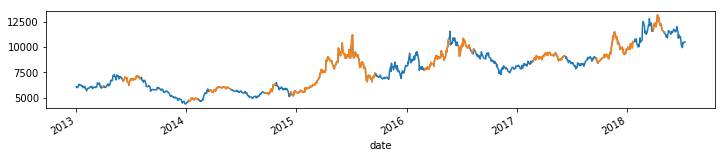

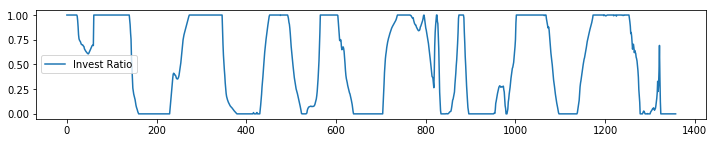

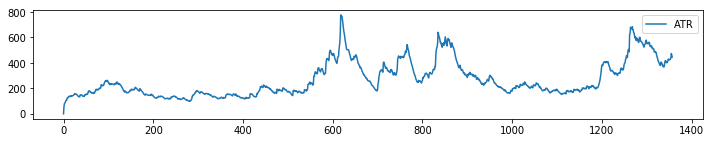

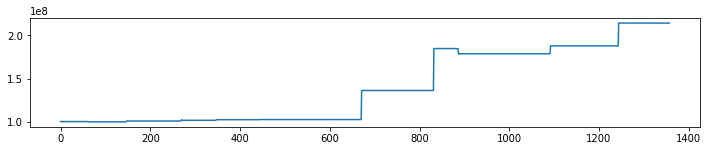

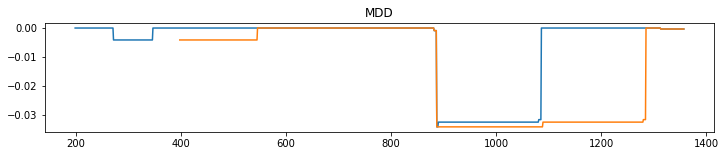

In [85]:
title = '수급 백테스팅'

kelly_factor = True
stop_loss_factor = False

capital = 100000000
fee = 0.00015
tax = 0.003
stop_loss_multiplier = 1
stop_loss_price = 0
profit_loss_ratio = 1.2
portfolio_value = 0
stock_num = 0
capital_history = []

# 매수 시그널 만들기
agent_rank_df['Score-Short'] = agent_rank_df['Leading Agent Score'].rolling(20).mean()
agent_rank_df['Score-Long'] = agent_rank_df['Leading Agent Score'].rolling(60).mean()
agent_rank_df['BUY'] = agent_rank_df['Score-Short'] > agent_rank_df['Score-Long']

p = data['cls_prc']
# buy_signal = pd.Series([True] * len(p)) # 로직없이 매일 사고파는 전략
# buy_signal = data['cls_prc'].rolling(20).mean() > data['cls_prc'].rolling(60).mean() # 골든크로스 전략
buy_signal = agent_rank_df['BUY']
buy_signal = buy_signal.shift(1)
buy_signal_price = buy_signal * p
buy_signal_price.replace({0: np.nan}, inplace=True)
buy_signal_price.rename(columns={0: 'Buy'}, inplace=True)

p_1 = p.shift(1).fillna(p[0])
rt = (p - p_1)/p_1
kelly_df = kelly_criterion(rt, kp_ret, 60)

atr_df= atr(ohlcv)

for i in range(len(p)):

    stock_price = p[i]
    buy_price = (stock_price * (1 + fee))
    sell_price = (stock_price * (1 - fee - tax))

    if buy_signal[i] == False:

        # 매도
        if stock_num != 0:
            capital, stock_num, portfolio_value = sell(capital, sell_price, stock_num, portfolio_value)

    elif buy_signal[i] == True:

        # 매수
        if stock_num == 0:

            if kelly_factor == True:
                invest_ratio = kelly_df['Invest Ratio'][i]
                capital, stock_num, portfolio_value = buy(capital, invest_ratio, buy_price, stock_num, portfolio_value)
            elif kelly_factor == False:
                capital, stock_num, portfolio_value = buy(capital, 1, buy_price, stock_num, portfolio_value)
            stop_profit_price = stock_price + ((profit_loss_ratio * stop_loss_multiplier) * atr_df['ATR'][i]) # 익절 라인 새로 잡기
            stop_loss_price = stock_price - (stop_loss_multiplier * atr_df['ATR'][i]) # 손절 라인 새로 잡기

        elif stock_num != 0:

            if stop_loss_factor == True:
                # 손절
                if stock_price <= stop_loss_price:
#                     print('Stop LOSS: {} <= {}'.format(stock_price, stop_loss_price))
                    capital, stock_num, portfolio_value = sell(capital, sell_price, stock_num, portfolio_value)
                # 익절
                elif stock_price >= stop_profit_price:
#                     print('Stop PROFIT: {} >= {}'.format(stock_price, stop_profit_price))
                    capital, stock_num, portfolio_value = sell(capital, sell_price, stock_num, portfolio_value)

    total_capital = capital + portfolio_value
    capital_history.append(total_capital)

backtest_df = pd.DataFrame(capital_history)
backtest_df['Return'] = backtest_df[0].pct_change()
backtest_df['Benchmark'] = kp_ret
backtest_df['Excess Return'] = backtest_df['Return'] - backtest_df['Benchmark']
sharpe_ratio = backtest_df['Excess Return'].mean() / backtest_df['Excess Return'].std()

roll_max_prc = backtest_df[0].rolling(200).max()
drawdown = backtest_df[0] / roll_max_prc - 1.0
mdd = drawdown.rolling(200).min()

# 결과 출력
print(title)
print('수익률: {}'.format((capital_history[-1] - capital_history[0]) / capital_history[0]))
print('Sharpe Ratio: {}'.format(sharpe_ratio))
print('MDD: {}'.format(mdd.min()))

plt.rcParams["figure.figsize"] = (12, 2)

p.plot()
buy_signal_price.plot()
plt.show()

kelly_df.plot()
plt.show()

atr_df.plot()
plt.show()

plt.plot(capital_history)
plt.show()

plt.title('MDD')
drawdown.plot()
mdd.plot()
plt.show()